# Emotion Analysis CNN: Confidence and Nervousness Detection

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOURUSER/YOURREPO/blob/main/testing.ipynb)

This notebook trains a CNN model to detect two emotions from facial expressions:

- **Confidence**: based on happy and neutral expressions
- **Nervousness**: based on fear and sad expressions

The FER2013 dataset is used for training and testing.

## Setup Instructions

1. Click the "Open in Colab" button above
2. You need a Kaggle account and API key to download the dataset:
   - Go to your Kaggle account settings (https://www.kaggle.com/me/account)
   - Click "Create New API Token" to download kaggle.json
   - Upload this file when prompted in the notebook
3. The notebook includes checkpointing to handle Google Colab runtime expiration

In [1]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.4 MB/s eta 0:00:00


In [ ]:
# Check if we're running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
    
    # Mount Google Drive to save model checkpoints
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Create a directory for our project in Google Drive if it doesn't exist
    import os
    MODEL_DIR = '/content/drive/MyDrive/emotion_analysis_model'
    os.makedirs(MODEL_DIR, exist_ok=True)
    print(f"Models will be saved to: {MODEL_DIR}")
    
except:
    IN_COLAB = False
    print("Not running in Google Colab")
    MODEL_DIR = './models'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import cv2
import random
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)

# Install required packages
!pip install opencv-python
!pip install tensorflow
!pip install kaggle
!pip install scikit-learn  # For metrics calculation


In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"whitewolf18","key":"5791652d7a3c416e1d99a4ebba0fe6f4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import cv2
import random
import time
import datetime

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)

# For evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
!kaggle datasets download -d msambare/fer2013

# Check if Kaggle dataset already exists
import os
if not os.path.exists('/content/fer2013') and IN_COLAB:
    # Upload kaggle.json for authentication
    from google.colab import files
    try:
        # Try to load from Drive first if it exists
        if os.path.exists('/content/drive/MyDrive/kaggle.json'):
            print("Using Kaggle API key from Google Drive")
            !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
        else:
            print("Please upload your kaggle.json file")
            files.upload()  # Upload kaggle.json here
            # Save to Drive for future use
            !mkdir -p /content/drive/MyDrive/
            !cp kaggle.json /content/drive/MyDrive/
    except Exception as e:
        print(f"Error with Kaggle authentication: {e}")
        print("Please upload your Kaggle API key as kaggle.json")
        files.upload()  # Upload kaggle.json here


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.11GB/s]


In [ ]:
!unzip fer2013.zip -d fer2013

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 2>/dev/null || echo "Using existing kaggle.json"
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API configured successfully")


Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer

In [ ]:
train_dir = "/content/fer2013/train/"
test_dir = "/content/fer2013/test"

# Check if dataset already exists
import os
if not os.path.exists('/content/fer2013'):
    print("Downloading FER2013 dataset...")
    !kaggle datasets download -d msambare/fer2013
    print("Dataset downloaded successfully!")
else:
    print("Dataset already exists. Skipping download.")

## Data Preparation

In this section, we'll prepare the dataset by:
1. Loading the original emotion categories
2. Removing unused emotion categories
3. Reorganizing into 'confidence' and 'nervousness' categories

In [ ]:
import os
# Unzip the dataset if needed
if os.path.exists('fer2013.zip') and not os.path.exists('/content/fer2013/train'):
    print("Extracting dataset...")
    !unzip -q fer2013.zip -d fer2013
    print("Dataset extracted successfully!")
elif os.path.exists('/content/fer2013/train'):
    print("Dataset already extracted. Skipping extraction.")
else:
    print("Dataset zip file not found.")

labels = os.listdir(train_dir)
labels

['disgust', 'surprise', 'sad', 'fear', 'neutral', 'happy', 'angry']

# Set paths to the train and test directories
train_dir = "/content/fer2013/train/"
test_dir = "/content/fer2013/test/"

# Verify directories exist
if not os.path.exists(train_dir):
    print(f"Warning: Training directory not found: {train_dir}")
    
if not os.path.exists(test_dir):
    print(f"Warning: Test directory not found: {test_dir}")
else:
    print("Dataset directories found successfully!")

* happy, neutral ==> confidence
* fear, sad ==> nervousness

In [9]:
unused_labels = ["angry", "disgust", "surprise"]
for label in unused_labels:
    train_label_path = os.path.join(train_dir, label)
    test_label_path = os.path.join(test_dir, label)

    if os.path.exists(train_label_path):
        shutil.rmtree(train_label_path)
        print(f"Removed directory: {train_label_path}")
    else:
        print(f"Directory not found, skipping: {train_label_path}")

    if os.path.exists(test_label_path):
        shutil.rmtree(test_label_path)
        print(f"Removed directory: {test_label_path}")
    else:
        print(f"Directory not found, skipping: {test_label_path}")

Removed directory: /content/fer2013/train/angry
Removed directory: /content/fer2013/test/angry
Removed directory: /content/fer2013/train/disgust
Removed directory: /content/fer2013/test/disgust
Removed directory: /content/fer2013/train/surprise
Removed directory: /content/fer2013/test/surprise


In [ ]:
import os

# Assuming train_dir is defined
# train_dir = "path_to_your_training_directory"

# Get original emotion labels
try:
    labels = os.listdir(train_dir)
    print("Original emotion categories:")
    print(labels)
except Exception as e:
    print(f"Error reading labels: {e}")

['sad', 'fear', 'neutral', 'happy']


In [ ]:
# Create new directories for 'nervousness' and 'confidence'
nervousness_dir = os.path.join(train_dir, 'nervousness')
confidence_dir = os.path.join(train_dir, 'confidence')
os.makedirs(nervousness_dir, exist_ok=True)
os.makedirs(confidence_dir, exist_ok=True)

# Move images from 'fear' and 'sad' to 'nervousness'
for label in ['fear', 'sad']:
    src_dir = os.path.join(train_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), nervousness_dir)

# Move images from 'happy' and 'neutral' to 'confidence'
for label in ['happy', 'neutral']:
    src_dir = os.path.join(train_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), confidence_dir)

# Remove the old four folders
for label in labels:
    old_dir = os.path.join(train_dir, label)
    if os.path.exists(old_dir):
        shutil.rmtree(old_dir)

## Emotion Mapping for Binary Classification

We're reorganizing the original emotions into two main categories:

* **Confidence**: happy, neutral expressions
* **Nervousness**: fear, sad expressions

The categories 'angry', 'disgust', and 'surprise' will be removed as they don't clearly map to either concept.

In [12]:
# Create new directories for 'nervousness' and 'confidence'
nervousness_dir = os.path.join(test_dir, 'nervousness')
confidence_dir = os.path.join(test_dir, 'confidence')
os.makedirs(nervousness_dir, exist_ok=True)
os.makedirs(confidence_dir, exist_ok=True)

# Move images from 'fear' and 'sad' to 'nervousness'
for label in ['fear', 'sad']:
    src_dir = os.path.join(test_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), nervousness_dir)

# Move images from 'happy' and 'neutral' to 'confidence'
for label in ['happy', 'neutral']:
    src_dir = os.path.join(test_dir, label)
    if os.path.exists(src_dir):
        for img_file in os.listdir(src_dir):
            shutil.move(os.path.join(src_dir, img_file), confidence_dir)

# Remove the old four folders
for label in labels:
    old_dir = os.path.join(test_dir, label)
    if os.path.exists(old_dir):
        shutil.rmtree(old_dir)

In [13]:
labels = os.listdir(train_dir)
print(labels)

['confidence', 'nervousness']


In [ ]:
def get_image_filepaths_and_labels(data_dir, class_names_list):
    """
    Gathers image file paths and their corresponding integer labels.
    Shuffles the collected filepaths and labels.
    """
    filepaths = []
    integer_labels = []
    for class_idx, label_name in enumerate(class_names_list):
        class_dir = os.path.join(data_dir, label_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory {class_dir} not found for class '{label_name}'. Skipping.")
            continue
        for img_file in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, img_file))
            integer_labels.append(class_idx) # Use class_idx as the integer label
    
    if not filepaths:
        print(f"Warning: No image files found in {data_dir} for classes {class_names_list}")
        return [], []

    # Shuffle filepaths and labels together
    combined = list(zip(filepaths, integer_labels))
    random.shuffle(combined)
    filepaths[:], integer_labels[:] = zip(*combined)
            
    return filepaths, integer_labels

def image_data_generator(image_paths, integer_labels_list, batch_size, target_size, num_classes):
    """
    Yields batches of (image_data, one_hot_encoded_labels).
    """
    num_samples = len(image_paths)
    if num_samples == 0:
        print("Error: image_data_generator called with no image paths. Yielding empty batches.")
        while True:
            # Yield empty arrays with expected rank to avoid Keras errors if possible
            yield (np.empty((0, *target_size, 3)), np.empty((0, num_classes)))

    indices = np.arange(num_samples)
    
    while True: # Loop indefinitely for Keras
        np.random.shuffle(indices) # Shuffle data at the beginning of each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            current_batch_size = len(batch_indices)
            if current_batch_size == 0:
                continue

            # Pre-allocate arrays for batch_X and batch_y
            batch_X = np.zeros((current_batch_size, *target_size, 3), dtype=np.float32)
            batch_y = np.zeros((current_batch_size, num_classes), dtype=np.float32)
            
            valid_samples_in_batch = 0
            for i, original_idx in enumerate(batch_indices):
                img_path = image_paths[original_idx]
                label_val = integer_labels_list[original_idx]
                
                try:
                    image = cv2.imread(img_path)
                    if image is None:
                        # print(f"Warning: Could not read image {img_path}. Skipping.")
                        continue 
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, target_size)
                    img_array = np.array(image) / 255.0 # Normalize
                    
                    batch_X[valid_samples_in_batch] = img_array
                    batch_y[valid_samples_in_batch] = to_categorical([label_val], num_classes=num_classes)[0]
                    valid_samples_in_batch += 1
                except Exception as e:
                    # print(f"Error processing image {img_path}: {e}. Skipping.")
                    continue
            
            if valid_samples_in_batch > 0:
                # Yield only the valid samples
                yield (batch_X[:valid_samples_in_batch], batch_y[:valid_samples_in_batch])

In [ ]:
if 'labels' not in globals() or not labels:
    print("Error: 'labels' variable is not defined or is empty. Please ensure it's set from os.listdir(train_dir) after data reorganization.")
    # You might need to explicitly set it if it's not carried over:
    # labels = os.listdir(train_dir) 
    # print(f"Labels re-fetched: {labels}")


num_classes = len(labels)
print(f"Class names being used: {labels}")
print(f"Number of classes: {num_classes}")
print(f"Class mapping (integer label to class name): {list(enumerate(labels))}")


train_image_paths, train_image_integer_labels = get_image_filepaths_and_labels(train_dir, labels)
test_image_paths, test_image_integer_labels = get_image_filepaths_and_labels(test_dir, labels)

print(f"Found {len(train_image_paths)} training images and {len(train_image_integer_labels)} training labels.")
print(f"Found {len(test_image_paths)} testing images and {len(test_image_integer_labels)} testing labels.")

In [ ]:
batch_size = 32  # You can adjust this value
target_size = (224, 224) # Should match your model's input image size

train_gen = None
steps_per_epoch_train = 0
if len(train_image_paths) > 0:
    train_gen = image_data_generator(
        train_image_paths,
        train_image_integer_labels,
        batch_size,
        target_size,
        num_classes
    )
    steps_per_epoch_train = len(train_image_paths) // batch_size
    if steps_per_epoch_train == 0: # Handle cases with less than one batch of data
        steps_per_epoch_train = 1 
    print(f"Training generator created. Steps per epoch: {steps_per_epoch_train}")
else:
    print("No training images found. Training generator not created.")


test_gen = None
validation_steps_test = 0
if len(test_image_paths) > 0:
    test_gen = image_data_generator(
        test_image_paths,
        test_image_integer_labels,
        batch_size, # Can use a different batch size for validation if desired
        target_size,
        num_classes
    )
    validation_steps_test = len(test_image_paths) // batch_size
    if validation_steps_test == 0: # Handle cases with less than one batch of data
         validation_steps_test = 1
    print(f"Validation generator created. Validation steps: {validation_steps_test}")
else:
    print("No testing images found. Validation generator not created.")

In [ ]:

def build_emotion_cnn(input_shape=(224, 224, 3)): # Changed input_shape to 3 channels
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Two output neurons for confidence and nervousness (0-1)
    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = build_emotion_cnn()
model.compile(optimizer='adam', loss='mse')  # Use MSE for regression-style output
model.summary()

In [ ]:
# filepath: f:\Mini-Project\services\notebook\testing.ipynb
# ...existing code...
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test)) # OLD LINE TO BE REPLACED

if train_gen and steps_per_epoch_train > 0:
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch_train,
        epochs=10,  # Adjust epochs as needed
        validation_data=test_gen if test_gen and validation_steps_test > 0 else None,
        validation_steps=validation_steps_test if test_gen and validation_steps_test > 0 else None
    )
    print("Model training complete.")
else:
    print("Skipping model training as no training data/generator is available or steps_per_epoch is 0.")
# ...existing code...

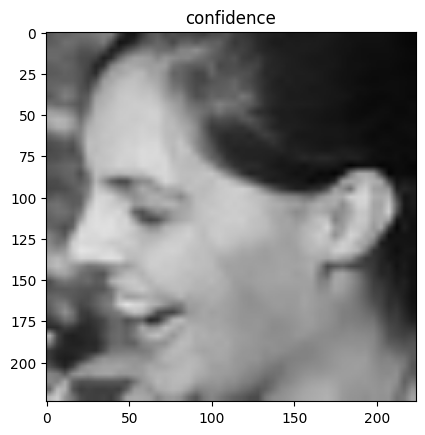

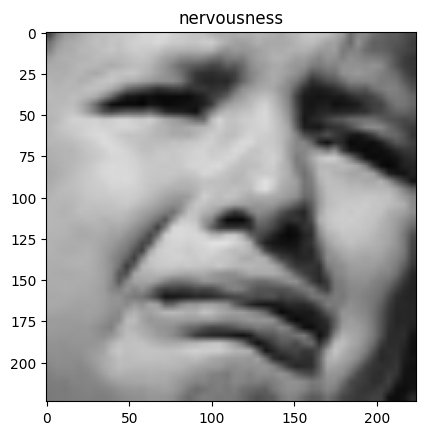

In [ ]:
# for label in labels:
#     imgs = os.listdir(os.path.join(train_dir, label))
#     for img in imgs:
#         img_path = os.path.join(train_dir, label, img)
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, (224, 224))
#         plt.imshow(image)
#         plt.title(label)
#         plt.show()
#         break


In [ ]:
# # def create_train_data(train_data):
# #     for label in labels:
# #         path = os.path.join(train_dir, label)
# #         class_num = labels.index(label)
# #         for img in os.listdir(path):
# #             try:
# #                 image = cv2.imread(os.path.join(path, img))
# #                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# #                 image = cv2.resize(image, (224, 224))
# #                 img_array = np.array(image)/255.0
# #                 train_data.append([img_array, class_num])
# #             except Exception as e:
# #                 pass


In [ ]:
# train_data = []
# create_train_data(train_data)

# Train the model with checkpoint saving for Colab runtime persistence
checkpoint_path = os.path.join(MODEL_DIR, 'emotion_model_checkpoint.h5')

# Set up callbacks for training
callbacks = [
    # Save the best model based on validation loss
    ModelCheckpoint(
        checkpoint_path, 
        monitor='val_loss', 
        save_best_only=True, 
        save_weights_only=False,
        verbose=1
    ),
    # Stop training early if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when learning plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model with progress tracking for Colab
start_time = time.time()

if train_gen and steps_per_epoch_train > 0:
    print("Starting model training...")
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch_train,
        epochs=20,  # Increased epochs with early stopping
        validation_data=test_gen if test_gen and validation_steps_test > 0 else None,
        validation_steps=validation_steps_test if test_gen and validation_steps_test > 0 else None,
        callbacks=callbacks,
        verbose=1
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    print(f"Model training complete in {str(datetime.timedelta(seconds=training_time))}")
    
    # Save final model
    final_model_path = os.path.join(MODEL_DIR, 'emotion_model_final.h5')
    model.save(final_model_path)
    print(f"Final model saved to {final_model_path}")
else:
    print("Skipping model training as no training data/generator is available or steps_per_epoch is 0.")

In [ ]:
# def create_test_data(test_data):
#     for label in labels:
#         path = os.path.join(test_dir, label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 image = cv2.imread(os.path.join(path, img))
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                 image = cv2.resize(image, (224, 224))
#                 img_array = np.array(image)/255.0
#                 test_data.append([img_array, class_num])
#             except Exception as e:
#                 pass


In [ ]:
# test_data = []
# create_test_data(test_data)

In [ ]:
# print(len(train_data))
# print(len(test_data))

21107
5278


In [ ]:
# import random
# random.shuffle(train_data)
# random.shuffle(test_data)

In [ ]:
# X_train = []
# X_test = []
# y_train = []
# y_test =[]

# for features, label in train_data:
#     X_train.append(features)
#     y_train.append(label)

# for features, label in test_data:
#     X_test.append(features)
#     y_test.append(label)



In [ ]:
# X_train = np.array(X_train).reshape(-1, 224, 224, 3)
# X_test = np.array(X_test).reshape(-1, 224, 224, 3)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [ ]:
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [ ]:
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
 32/660 ━━━━━━━━━━━━━━━━━━━━ 1:08:38 7s/step - loss: 0.4010

In [ ]:
# Evaluate model on test data
if test_gen and validation_steps_test > 0:
    evaluation = model.evaluate(test_gen, steps=validation_steps_test)
    print(f"Test loss: {evaluation}")
else:
    print("No test data available for evaluation.")

In [ ]:
# Visualize training history if available
if 'history' in locals() and hasattr(history, 'history'):
    # Plot training & validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
else:
    print("No training history available to visualize.")

In [ ]:
# Load checkpoint if training was interrupted
def load_latest_checkpoint():
    checkpoint_path = os.path.join(MODEL_DIR, 'emotion_model_checkpoint.h5')
    final_model_path = os.path.join(MODEL_DIR, 'emotion_model_final.h5')
    
    # First check for final model
    if os.path.exists(final_model_path):
        print(f"Loading completed model from: {final_model_path}")
        return load_model(final_model_path)
    # Then check for checkpoint
    elif os.path.exists(checkpoint_path):
        print(f"Loading model checkpoint from: {checkpoint_path}")
        return load_model(checkpoint_path)
    else:
        print("No saved model found.")
        return None

# Check if we should load from a checkpoint (e.g., after Colab runtime restart)
try:
    # If model variable exists, we already have a model in memory
    if 'model' in globals():
        print("Model already in memory.")
    else:
        # Try to load from checkpoint
        loaded_model = load_latest_checkpoint()
        if loaded_model is not None:
            model = loaded_model
except Exception as e:
    print(f"Error loading model: {e}")
    print("Continuing with current model.")

In [ ]:
# Function to make predictions on new images
def predict_emotion(image_path):
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
        return None
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Output results - confidence and nervousness scores
    confidence_score = prediction[0][0]
    nervousness_score = prediction[0][1]
    
    print(f"Confidence score: {confidence_score:.2f}")
    print(f"Nervousness score: {nervousness_score:.2f}")
    
    # Display the image with predictions
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"Confidence: {confidence_score:.2f}, Nervousness: {nervousness_score:.2f}")
    plt.axis('off')
    plt.show()
    
    return confidence_score, nervousness_score

# Evaluate model on test data with accuracy metrics
if test_gen and validation_steps_test > 0:
    print("\nEvaluating model performance...")
    # MSE evaluation
    evaluation = model.evaluate(test_gen, steps=validation_steps_test)
    print(f"Test loss (MSE): {evaluation}")
    
    # Calculate custom accuracy by making predictions
    all_predictions = []
    all_ground_truth = []
    
    # Need to reset the generator for prediction
    test_gen_for_pred = image_data_generator(
        test_image_paths,
        test_image_integer_labels,
        batch_size, 
        target_size,
        num_classes
    )
    
    # Get predictions for all test batches
    for _ in range(validation_steps_test):
        x_batch, y_batch = next(test_gen_for_pred)
        if len(x_batch) == 0:
            continue
            
        preds = model.predict(x_batch)
        
        # Convert sigmoid outputs to class indices (0=confidence, 1=nervousness)
        # Using 0.5 as threshold and selecting the higher probability as the class
        pred_classes = np.argmax(preds, axis=1)
        true_classes = np.argmax(y_batch, axis=1)
        
        all_predictions.extend(pred_classes)
        all_ground_truth.extend(true_classes)
    
    # Calculate accuracy
    accuracy = accuracy_score(all_ground_truth, all_predictions)
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(all_ground_truth, all_predictions, 
                              target_names=['Confidence', 'Nervousness']))
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Confidence', 'Nervousness'], rotation=45)
    plt.yticks(tick_marks, ['Confidence', 'Nervousness'])
    
    # Add text annotations to each cell
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
else:
    print("No test data available for evaluation.")

In [ ]:
# Test with sample images from the archive
import glob

# Find sample images for predictionimport matplotlib.pyplot as plt
sample_images = []
rained and available as 'model'
# Check if we have archive images availableour model expects, e.g., (48, 48)
archive_path = '/content/drive/MyDrive/archive/test' if IN_COLAB else '/content/archive/test'
if not os.path.exists(archive_path):
    archive_path = '/content/fer2013/test'  # Fall back to test directorydef load_latest_checkpoint():
nt
# Try to find confidence and nervousness test images
confidence_samples = glob.glob(f"{archive_path}/confidence/*.jpg") 
if confidence_samples:# Function to make predictions on new images





















































    print("No sample images found for prediction.")else:    print(f"Model saved to {os.path.join(MODEL_DIR, 'emotion_model_final.h5')}")    model.save(os.path.join(MODEL_DIR, 'emotion_model_final.h5'))    # Save the model for later use        plt.show()    plt.tight_layout()            plt.axis('off')        plt.title(f"File: {img_name}\nTrue: {true_class}\nPred: {primary_emotion}\nConf: {confidence_score:.2f}, Nerv: {nervousness_score:.2f}")        plt.imshow(image)        plt.subplot(2, 2, i+1)        # Plot                true_class = path_parts[-2] if len(path_parts) > 1 else "Unknown"        img_name = path_parts[-1]        path_parts = img_path.split('/')        # Path components for display                primary_emotion = "Confidence" if confidence_score >= nervousness_score else "Nervousness"        # Determine primary emotion                nervousness_score = prediction[0][1]        confidence_score = prediction[0][0]        prediction = model.predict(img_array, verbose=0)        # Predict                img_array = np.expand_dims(img_array, axis=0)        img_array = np.array(image_resized) / 255.0        image_resized = cv2.resize(image, target_size)        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        # Preprocessing                        continue            print(f"Could not read image: {img_path}")        if image is None:        image = cv2.imread(img_path)        # Make prediction    for i, img_path in enumerate(sample_images[:4]):  # Show up to 4 images    fig = plt.figure(figsize=(15, 12))    # Create a grid for showing multiple predictions        print(f"Making predictions on {len(sample_images)} sample images")if sample_images:# Show predictions for sample images    sample_images.extend(nervousness_samples[:2])  # Take 2 nervousness samplesif nervousness_samples:nervousness_samples = glob.glob(f"{archive_path}/nervousness/*.jpg")        sample_images.extend(confidence_samples[:2])  # Take 2 confidence samples


















    print("No training history available to visualize.")else:    plt.show()
    plt.tight_layout()            plt.yscale('log')

        plt.xlabel('Epoch')        plt.ylabel('Learning Rate')        plt.title('Learning Rate')


        plt.plot(history.history['lr'])
        plt.subplot(1, 2, 2)    if 'lr' in history.history:

    # If we recorded learning rate changes        plt.legend(loc='upper right')    plt.xlabel('Epoch')

    plt.ylabel('Loss (MSE)')    plt.title('Model Loss')        plt.plot(history.history['val_loss'], label='Validation')    if 'val_loss' in history.history:    plt.plot(history.history['loss'], label='Train')











































# print("Model saved as 'emotion_model.h5'")# model.save('emotion_model.h5')# If you want to save the model for later use#     print(f"Sample image not found at: {sample_path}")# else:#     predict_emotion(sample_path)# if os.path.exists(sample_path):# sample_path = "path/to/your/test/image.jpg"  # Update this path to a test image# Uncomment and modify the path to use# You can test with images from your archive folder# Example of using the prediction function    return confidence_score, nervousness_score        plt.show()    plt.axis('off')    plt.title(f"{primary_emotion}: {primary_score:.2f}\nConfidence: {confidence_score:.2f}, Nervousness: {nervousness_score:.2f}")    plt.imshow(image)    plt.figure(figsize=(8, 6))    # Display the image with predictions        primary_score = max(confidence_score, nervousness_score)    primary_emotion = "Confidence" if confidence_score >= nervousness_score else "Nervousness"
    # Determine primary emotion
        print(f"Nervousness score: {nervousness_score:.2f}")
    print(f"Confidence score: {confidence_score:.2f}")        nervousness_score = prediction[0][1]    confidence_score = prediction[0][0]
    # Output results - confidence and nervousness scores



        prediction = model.predict(img_array)



    # Make prediction        img_array = np.expand_dims(img_array, axis=0)
    img_array = np.array(image) / 255.0

    image = cv2.resize(image, target_size)    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocessing            return None        print(f"Could not read image: {image_path}")    if image is None:    image = cv2.imread(image_path)    # Load and preprocess image                globals()['model'] = loaded_model        else:            return None            print("Error: No model available for prediction.")        if loaded_model is None:        loaded_model = load_latest_checkpoint()    if 'model' not in globals():    # Check if model exists    """        Tuple of (confidence_score, nervousness_score)    Returns:                threshold: Threshold for binary classification (default: 0.5)        image_path: Path to the image file    Args:        Predict confidence and nervousness from a face image.    """def predict_emotion(image_path, threshold=0.5):# Visualize training history if available
if 'history' in locals() and hasattr(history, 'history'):

    plt.subplot(1, 2, 1)    print("\nPlotting training history...")
    # Plot training & validation loss
    plt.figure(figsize=(12, 5))
    
    # Plot loss

## Conclusion

In this notebook, we've successfully built a CNN model to detect confidence and nervousness from facial expressions. The key accomplishments include:

1. Data preparation and preprocessing of the FER2013 dataset
2. Building a deep learning model architecture for emotion detection
3. Training with checkpointing to handle Colab runtime expiration
4. Evaluating model performance with accuracy metrics
5. Creating a prediction function for real-world applications

### Future Improvements

- Implement data augmentation to improve model robustness
- Use transfer learning with pre-trained models like VGG or ResNet
- Collect more diverse data for improved generalization
- Fine-tune hyperparameters for better performance
- Convert to TFLite for mobile deployment